In [157]:
import os
import re
import json
import spacy
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from spacy import displacy
from read_problems import read_questions_json
from read_problems import read_all_problems
from read_problems import write_problems
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.tokenizer import Tokenizer

%matplotlib inline

In [106]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [152]:
# Load English tokenizer, tagger, parser, NER and word vectors
nlp = spacy.load('en')

In [274]:
class QuestionCategory(object):
    DEF_KEYWORD = 0
    DEF_KEYWORD_START_END = 1
    KEYWORD_DEF = 2
    KEYWORD_DEF_START_END = 3
    
    CHAR_KEYWORD = 4
    KEYWORD_CHAR = 5
    SITUATION_KEYWORD = 6
    KEYWORD_SITUATION = 7
    SITUATION_CHAR = 8
    CHAR_SITUATION = 9
    SITUATION_ACTION = 10
    ACTION_EFFECT = 11
    ACTION_REASON = 12
    KEYWORD_COMPARISON = 13
    SITUATION_DEF = 14
    CALCULUS = 15
    REASONING = 16
    
    UNKNOWN = 100
    
    OTHER = 666

In [247]:
def load_glossary():
    path = os.path.join('..', 'Data', 'material_handbook', 'glossary_manual.json')
    return json.load(open(path))

def calculate_average_question_len(q):
    res = q['choice_A_len'] + \
          q['choice_B_len'] + \
          q['choice_C_len']
    if q['choice_D'] is np.NaN:
        return res / 3
    res += q['choice_D_len']
    return res / 4

def add_length_features(df):
    df['question_len'] = df['question'].str.len()
    df['choice_A_len'] = df['choice_A'].str.len()
    df['choice_B_len'] = df['choice_B'].str.len()
    df['choice_C_len'] = df['choice_C'].str.len()
    df['choice_D_len'] = df['choice_D'].str.len()
    df['average_question_len'] = df.apply(calculate_average_question_len, axis=1)
    df['question_choice_len_ratio'] = df['question_len'] / df['average_question_len']

def is_roman(word):
    return re.match('^[IVXLC]+$', word) is not None

def get_keyword(term):
    words = term.split(' ')
    words = [x.lower() for x in words if is_roman(x) or x.lower() not in STOP_WORDS]
    return ' '.join(words)

def is_in_glossary(term, glossary):
    if term is np.NaN:
        return False
    keyword = term
    if keyword not in glossary:
        keyword = get_keyword(term)
    return keyword in glossary
    
def sentence_with_term(sentence, glossary):
    if sentence is np.NaN:
        return False
    for keyword, definition in glossary.items():
        if keyword.lower() in sentence.lower():
            return True
    return False

def any_choice_in_glossary(df):
    if df['choice_D'] is np.NaN:
        return df['choice_A_in_glossary'] or \
               df['choice_B_in_glossary'] or \
               df['choice_C_in_glossary']
    return df['choice_A_in_glossary'] or \
           df['choice_B_in_glossary'] or \
           df['choice_C_in_glossary'] or \
           df['choice_D_in_glossary']

def add_glossary_features(df):
    glossary = load_glossary()
    df['choice_A_in_glossary'] = df['choice_A'].apply(lambda choice: is_in_glossary(choice, glossary))
    df['choice_B_in_glossary'] = df['choice_B'].apply(lambda choice: is_in_glossary(choice, glossary))
    df['choice_C_in_glossary'] = df['choice_C'].apply(lambda choice: is_in_glossary(choice, glossary))
    df['choice_D_in_glossary'] = df['choice_D'].apply(lambda choice: is_in_glossary(choice, glossary))
    df['any_choice_in_glossary'] = df.apply(any_choice_in_glossary, axis=1)

def has_numbers(problem):
    question = problem['question']
    for token in problem['question_nlp']:
        if token.is_digit:
            return True
    return False

def get_ner(problem, nlp_q):
    question = problem['question']
    ent_type_ids = set()
    ent_types = []
    for token in problem[nlp_q]:
        if token.ent_type != 0 and token.ent_type not in ent_type_ids:
            ent_type_ids.add(token.ent_type)
            ent_types.append(token.ent_type_)
    if len(ent_types) == 0:
        return None
    return ent_types

def has_person(problem):
    return problem['question_ner'] is not None and 'PERSON' in problem['question_ner']

def predict(nlp, wiki_nlp, df, category, filters_factory):
    add_length_features(df)
    add_glossary_features(df)
    df['question_nlp'] = df['question'].apply(lambda q: nlp(q))
    df['question_wiki_nlp'] = df['question'].apply(lambda q: wiki_nlp(q))
    df['question_has_digits'] = df.apply(has_numbers, axis=1)
    df['question_ner'] = df.apply(lambda p: get_ner(p, 'question_nlp'), axis=1)
    df['question_has_person'] = df.apply(has_person, axis=1)
    df['predicted_category'] = QuestionCategory.OTHER
    df.loc[filters_factory(df), 'predicted_category'] = category
    all_df.drop(['question_len', 'choice_A_len', 'choice_B_len', 'choice_C_len', 'choice_D_len', 'average_question_len', 'filename', 'comments', 'choice_A_in_glossary', 'choice_B_in_glossary', 'choice_C_in_glossary', 'choice_D_in_glossary'], axis=1, inplace=True)

In [227]:
wiki_nlp = spacy.load('xx_ent_wiki_sm')

Confusion matrix, without normalization
             precision    recall  f1-score   support

          0       0.53      0.96      0.69        24
          1       0.00      0.00      0.00         3
        666       1.00      0.99      0.99      2060

avg / total       0.99      0.99      0.99      2087



/home/abiarnes/VirtualEnvs/MDI720/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


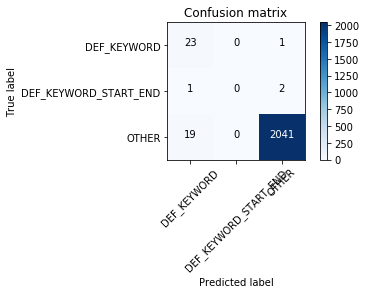

In [248]:
def get_def_keyword_filters(df):
    filters = ~df['question'].str.contains(', CFA,')
    filters &= (df['question'].str.contains('described as') |
               df['question'].str.contains('defined as'))
    filters &= df['question_choice_len_ratio'] < 27.0
    filters &= df['any_choice_in_glossary']
    filters &= ~df['question_has_digits']
    filters &= ~df['question_has_person']
    return filters

all_df = read_all_problems()
all_df['real_category'] = all_df['category']
filters = all_df['category'] != QuestionCategory.DEF_KEYWORD
filters &= all_df['category'] != QuestionCategory.DEF_KEYWORD_START_END
all_df.loc[filters, 'category'] = QuestionCategory.OTHER

predict(nlp, wiki_nlp, all_df, QuestionCategory.DEF_KEYWORD, get_def_keyword_filters)

y_pred = all_df['predicted_category']
y_test = all_df['category']
plot_confusion_matrix(confusion_matrix(y_test, y_pred), ['DEF_KEYWORD', 'DEF_KEYWORD_START_END', 'OTHER'])
print(classification_report(y_test, y_pred))

In [ ]:
def display_dependencies(sentence):
    doc = nlp(sentence)
    displacy.render(doc, style='dep', jupyter=True)

In [278]:
def set_category(index, cat):
    all_df.loc[index, 'category'] = cat
    all_df.loc[index, 'real_category'] = cat

In [286]:
all_df = read_all_problems()

In [287]:
set_category(1901, QuestionCategory.DEF_KEYWORD)
set_category(1902, QuestionCategory.DEF_KEYWORD)
set_category(1944, QuestionCategory.KEYWORD_DEF_START_END)
set_category(1967, QuestionCategory.SITUATION_KEYWORD)
set_category(1994, QuestionCategory.SITUATION_KEYWORD)

In [288]:
write_problems(all_df)

In [283]:
all_df.loc[1994, 'question']

'A trader is able to obtain persistent abnormal returns by adopting an investment strategy that purchases stocks that have recently experienced high returns. This strategy exploits a market pricing anomaly best described as:'

In [277]:
filters = all_df['predicted_category'] == QuestionCategory.DEF_KEYWORD
filters &= all_df['real_category'] == QuestionCategory.OTHER
all_df[filters]

,answer,category,choice_A,choice_B,choice_C,choice_D,question,question_nb,topic,year,real_category,question_choice_len_ratio,any_choice_in_glossary,question_nlp,question_wiki_nlp,question_has_digits,question_ner,question_has_person,predicted_category
1901,B,666,internal rate of return,required rate of return,expected return,NaN,The minimum rate of return an investor must re...,29,Quantitative Methods,2015,666,5.409836,True,"(The, minimum, rate, of, return, an, investor,...","(The, minimum, rate, of, return, an, investor,...",False,None,False,0
1902,A,666,parameter,frequency distribution,sample statistic,NaN,A descriptive measure of a population characte...,31,Quantitative Methods,2015,666,4.851064,True,"(A, descriptive, measure, of, a, population, c...","(A, descriptive, measure, of, a, population, c...",False,None,False,0
1944,C,666,forward contract,option contract,asset,NaN,Convenience yield is best described as a nonmo...,102,Derivative Investments,2015,666,6.416667,True,"(Convenience, yield, is, best, described, as, ...","(Convenience, yield, is, best, described, as, ...",False,[GPE],False,0
1967,A,666,complements,substitutes,preferences,NaN,In the demand function f = 4.3 – 0.7P +.031 – ...,42,Economics,2017,666,21.363636,True,"(In, the, demand, function, f, =, 4.3, –, 0.7P...","(In, the, demand, function, f, =, 4.3, –, 0.7P...",False,"[PERCENT, ORG]",False,0
1994,C,666,the overreaction effect,data mining,momentum,NaN,A trader is able to obtain persistent abnormal...,81,Equity Investments,2017,666,15.928571,True,"(A, trader, is, able, to, obtain, persistent, ...","(A, trader, is, able, to, obtain, persistent, ...",False,None,False,0


In [236]:
def print_question_ner(index):
    print(all_df.loc[index]['question'])
    sentence = nlp(all_df.loc[index]['question'])
    for token in sentence:
        if token.ent_type != 0:
            print("%s => %s, %s" % (token, token.ent_type_, token.ent_iob_))

filters = all_df['predicted_category'] == QuestionCategory.DEF_KEYWORD
filters &= all_df['category'] != QuestionCategory.DEF_KEYWORD
filters &= ~all_df['question_ner'].isnull()
for i in all_df[filters].index:        
    print_question_ner(i)
    print()

Howard Quarries has recently opened a limestone quarry at a location outside their traditional service area. Because  limestone is a major ingredient in concrete, if the quarry is successful Howard plans to build a ready-mix concrete plant at  the same location. The investment in the concrete plant is best described as:
Howard => PERSON, B
Quarries => PERSON, I
Howard => PERSON, B

A company's optimal capital budget is best described as the amount of new capital required to undertake all projects with an  internal rate of return greater than the:
  => NORP, B

A test statistic is best defined as the difference between the sample statistic and the value of the population parameter under H0 divided by the:
H0 => ORG, B

Over a given period, the price of a commodity falls by 5.0% and the quantity demanded rises by 7.5%. The price elasticity of demand for the commodity is best described as:
a => DATE, B
given => DATE, I
period => DATE, I
5.0 => PERCENT, B
% => PERCENT, I
7.5 => PERCENT, B


In [57]:
found_def = definitions[definitions['category'] == QuestionCategory.DEF_KEYWORD]
# definitions[definitions['category'] == QuestionCategory.DEF_KEYWORD]
not_found_def = all_df.loc[all_df['category'] == QuestionCategory.DEF_KEYWORD]
not_found_def = not_found_def.loc[~not_found_def.index.isin(found_def.index)]

print("total len %d" % len(all_df))
print("found def len %d" % len(found_def))
print("not_found_def len %d" % len(not_found_def))

not_found_def.head()

precision = 

total len 2087
found def len 24
not_found_def len 1


,answer,category,choice_A,choice_B,choice_C,choice_D,comments,filename,question,question_nb,...,choice_B_len,choice_C_len,choice_D_len,average_question_len,question_choice_len_ratio,choice_A_in_glossary,choice_B_in_glossary,choice_C_in_glossary,choice_D_in_glossary,any_choice_in_glossary
601,B,0,binomial distribution,discrete uniform distribution,continuous uniform distribution,NaN,"“Common Probability Distributions,” Richard A....",2010_morning_answer.xml,A random variable with a finite number of equa...,19,...,29,31,NaN,27.0,3.296296,True,True,True,False,True


In [15]:
question = nlp(all_df.loc[26]['question'])
choiceA = nlp('a probability distribution that summarizes the likelihood that a value will take one of two independent values under a given set of parameters or assumptions')
choiceB = nlp('A psychological phenomenon that explains why people tend to seek out information that confirms their existing opinions and overlook or ignore information that refutes their beliefs')
choiceC = nlp(all_df.loc[26]['choice_C'])
choiceD = nlp(all_df.loc[26]['choice_D'])

print(question.similarity(choiceA))
print(question.similarity(choiceB))
print(question.similarity(choiceC))
print(question.similarity(choiceD))

choiceD.has_vector

0.4446638748095584
0.34034696278557064
0.27845460590124105
0.14654814882619355


True

In [22]:
def get_search_text(index):
    problem = all_df.loc[index]
    question = problem['question']
    choiceA = problem['choice_A']
    choiceB = problem['choice_B']
    choiceC = problem['choice_C']
    choiceD = problem['choice_D']
    return ' '.join((question, choiceA, choiceB, choiceC, choiceD))

get_search_text(26)

'If an analyst estimates the probability of an event for which there is no historical record, this probability is best  described as: a priori objective empirical subjective'

In [5]:
all_df[all_df['question'].str.contains('described') | all_df['question'].str.contains('defined')]

,answer,category,choice_A,choice_B,choice_C,choice_D,comments,filename,question,question_nb,topic,year
26,D,1,a priori,objective,empirical,subjective,"""Probability Concepts,"" Richard A. Defusco, De...",2008_part_1.xml,If an analyst estimates the probability of an ...,27,Quantitative Methods,2008
102,A,2,Z-spread minus the option cost,Z-spread plus the cost of the option,value of the security's embedded option,effect of changes in interest rates on the val...,"""Yield Measures, Spot Rates, and Forward Rates...",2008_part_1.xml,The option adjusted spread (OAS) is best descr...,103,Fixed Income Investments,2008
142,A,6,ratio,ordinal,interval,nominal,"“Statistical Concepts and Market Returns,” Ric...",2008_part_2.xml,An analyst gathered the price-earnings ratios ...,23,Quantitative Methods,2008
189,D,6,an externality,project sequencing,a mutually exclusive project,an example of investment synergy,"“Capital Budgeting,” JohnD. Stowe and Jacques ...",2008_part_2.xml,Howard Quarries has recently opened a limeston...,70,Corporate Finance,2008
192,D,3,marginal cost of capital,cost of new debt capital,cost of retained earnings,weighted average cost of capital,"“Cost of Capital,” Yves Courtois, GeneC. Lai, ...",2008_part_2.xml,A company's optimal capital budget is best des...,73,Corporate Finance,2008
318,B,3,only interest payments to debt holders,payments to both debt holders (interest and pr...,both interest and principal payments to debt h...,NaN,"“Understanding the Cash Flow Statement,” Thoma...",2009_afternoon_answers.xml,Free cash flow to equity is most accurately de...,86,Equity Investments,2009
375,C,1,a priori,empirical,subjective,NaN,"“Probability Concepts,” Richard A. Defusco, CF...",2009_morning_answers.xml,If an analyst estimates the probability of an ...,26,Quantitative Methods,2009
391,A,4,Price stability,Full employment,Moderating long-term interest rates,NaN,"“Monetary Policy,” Michael Parkin 2009 Modular...",2009_morning_answers.xml,Which of the following goals of monetary polic...,43,Economics,2009
431,A,0,escalation bias,confirmation bias,overconfidence bias,NaN,"“Efficient Capital Markets,” Frank K. Reilly, ...",2009_morning_answers.xml,The behavior of investors who put more money i...,84,Equity Investments,2009
438,B,0,interest rate cap,interest rate floor,interest rate collar,NaN,"“Option Markets and Contracts,” Don M. Chance ...",2009_morning_answers.xml,A series of interest rate put options that exp...,91,Derivative Investments,2009


In [22]:
all_df.loc[192]['question']

"A company's optimal capital budget is best described as the amount of new capital required to undertake all projects with an  internal rate of return greater than the:"

In [30]:
all_df[all_df['category'] == QuestionCategory.CALCULUS]

,answer,category,choice_A,choice_B,choice_C,choice_D,comments,filename,question,question_nb,topic,year
1038,C,15,3.13%,42.40%,73.50%,NaN,"""Understanding Yield Spreads,"" Frank J. Fabozz...",2012_afternoon_answer.xml,If the yield on a 5-year U.S. corporate bond i...,101,Fixed Income Investments,2012


In [18]:
all_df.loc[1693]['question']

'The value at risk of an alternative investment is best described as the:'

In [20]:
all_df = read_all_problems()

In [123]:
write_problems(all_df)

In [120]:
all_df.loc[1226]['question']

'In the audit report, an additional paragraph that explains an exception to an accounting standard is best described as a(n):'

In [7]:
potential_defs = all_df[(all_df['question'].str.contains('defined') | all_df['question'].str.contains('described'))]
potential_defs[potential_defs['category'] == QuestionCategory.OTHER].loc[1095:]

,answer,category,choice_A,choice_B,choice_C,choice_D,comments,filename,question,question_nb,topic,year
1270,B,666,size of the contract,original time to maturity,net amount owed by one party to the other,NaN,"""Swap Markets and Contracts,"" Don M. Chance, C...",2013_afternoon_answer.xml,The tenor of a swap is best described as the:,95,Derivative Investments,2013
1294,B,666,market factor model,fundamental factor model,macroeconomic factor model,NaN,"""Portfolio Risk and Return Part II"", Vijay Sin...",2013_afternoon_answer.xml,A return-generating model that provides an est...,119,Portfolio Management,2013
1315,B,666,platykurtotic (less peaked than a normal distr...,leptokurtotic (more peaked than a normal distr...,mesokurtotic (identical to the normal distribu...,NaN,"""Statistical Concepts and Market Returns,"" Ric...",2013_morning_answer.xml,"Equity return series are best described as, fo...",20,Quantitative Methods,2013
1320,A,666,support level,resistance level,change in polarity point,NaN,"""Technical Analysis,"" Barry M. Sine, CFA and R...",2013_morning_answer.xml,A stock is declining in price and reaches a pr...,25,Quantitative Methods,2013
1324,A,666,risk of loss relative to an investment's fair ...,increased sensitivity of the market value of d...,possibility that the borrower will fail to mak...,NaN,"""The Time Value of Money,"" Richard A. DeFusco,...",2013_morning_answer.xml,The liquidity premium can be best described as...,29,Quantitative Methods,2013
1333,C,666,E,G,F+H,NaN,"""Demand and Supply Analysis: Introduction,"" Ri...",2013_morning_answer.xml,The diagram to the right shows the domestic de...,38,Economics,2013
1340,B,666,as liquid,less liquid,more liquid,NaN,"""Understanding Balance Sheets,"" Elaine Henry, ...",2013_morning_answer.xml,The current ratio for an industry is 3.2. Data...,45,Financial Statement Analysis,2013
1354,C,666,timeliness and accrual accounting,understandability and verifiability,relevance and faithful representation,NaN,"""Financial Reporting Standards,"" Elaine Henry,...",2013_morning_answer.xml,According to the International Accounting Stan...,59,Financial Statement Analysis,2013
1386,A,666,swap,futures contract,forward contract,NaN,"""Derivative Markets and Instruments,"" Don M. C...",2013_morning_answer.xml,A corporation issues 5-year fixed-rate bonds. ...,91,Derivative Investments,2013
1405,B,666,price return,collateral yield,convenience yield,NaN,"""Investing in Commodities,"" Ronald G. Layard-L...",2013_morning_answer.xml,If an investor uses derivatives to make a long...,110,Alternative Investments,2013


In [31]:
question = 'Which of the following statements regarding correlation and covariance is most likely correct? The correlation  between two random variables is their covariance standardized by the:'

def is_start_end_definition(question):
    match = re.match('^.*[.!?] The([^.!?]*) is [^.!?]*:$', question)
    return not match is None

def extract_last_sentence(question):
    match = re.match('^([^.!?]*[.!?:])+$', question)
    return match.group(1).strip()

extract_last_sentence(question)

'The correlation  between two random variables is their covariance standardized by the:'

In [ ]:
test.loc[93]['question']

In [32]:
from spacy.symbols import nsubj, VERB

def display_root(sentence):
    doc = nlp(sentence)
    root = [token for token in doc if token.head == token][0]
    print(root)

def display_dependencies(sentence):
    doc = nlp(sentence)
    displacy.render(doc, style='dep', jupyter=True)

In [15]:
for sentence in last_sentences:
    display_root(sentence)

NameError: name 'last_sentences' is not defined

In [33]:
last_sentences = test['question'].apply(extract_last_sentence).values
last_sentences

NameError: name 'test' is not defined

In [ ]:
display_depencies(last_sentences[2])

In [ ]:
def_filter = potential_def['question'].apply(is_start_end_definition)
test = potential_def[def_filter]
test_filtered = test[['answer', 'choice_A', 'choice_B', 'choice_C', 'choice_D', 'question']].copy()
test_filtered['category'] = QuestionCategory.OTHER

In [ ]:
test_filtered

In [ ]:
test_filtered.loc[2375, 'question']

In [ ]:
potential_def.loc[27]['question']

In [ ]:
potential_def.loc[0:30]

In [ ]:
all_df.loc[2380]['question']

In [ ]:
get_best_documents(docs_df, ['callable bond', 'negative convexity'])

In [ ]:
get_text_by_id(docs_df, 'Investopedia_41106')